## Complete Feature Engineering and Model Training

### **Data Preprocessing**

In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('dataset/Visa.csv')
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [4]:
df.shape

(25480, 12)

In [5]:
# Checking for null values

df.isnull().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

In [6]:
# Checking for duplicates

df.duplicated().sum()

0

In [7]:
# Removing case_id column as it is not required for Model Training

df.drop('case_id', inplace = True, axis = 1)

### **Feature Engineering**

#### Feature Extraction

In [8]:
df.head(3)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied


We will replace `year of establishment` with the `age of the company`, which is calculated as the difference between the current year and the year of establishment. This will help in understanding how long the company has been in operation, which can be a significant factor in visa approval.

In [9]:
from datetime import date

todays_date = date.today()
current_year = todays_date.year

print(current_year)

2025


In [10]:
# Subtract current year with year of estab to get company's age
df['company_age'] = current_year - df['yr_of_estab']

# Dropping the yr_or_estab column
df.drop('yr_of_estab', inplace = True, axis = 1) 

In [11]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,Certified,20


#### Types of Features

In [12]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(numerical_features))

categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(categorical_features))

discrete_features=[feature for feature in numerical_features if len(df[feature].unique()) <= 25]
print('Num of Discrete Features :',len(discrete_features))

continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Numerical Features : 3
Num of Categorical Features : 8
Num of Discrete Features : 0
Num of Continuous Features : 3


#### Dependent and Independent Features

In [13]:
X = df.drop('case_status', axis = 1)
Y = df['case_status']

In [14]:
Y.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

In [15]:
# Encoding the target column

Y = np.where(Y == 'Denied', 0, 1)

#### Feature Transformation

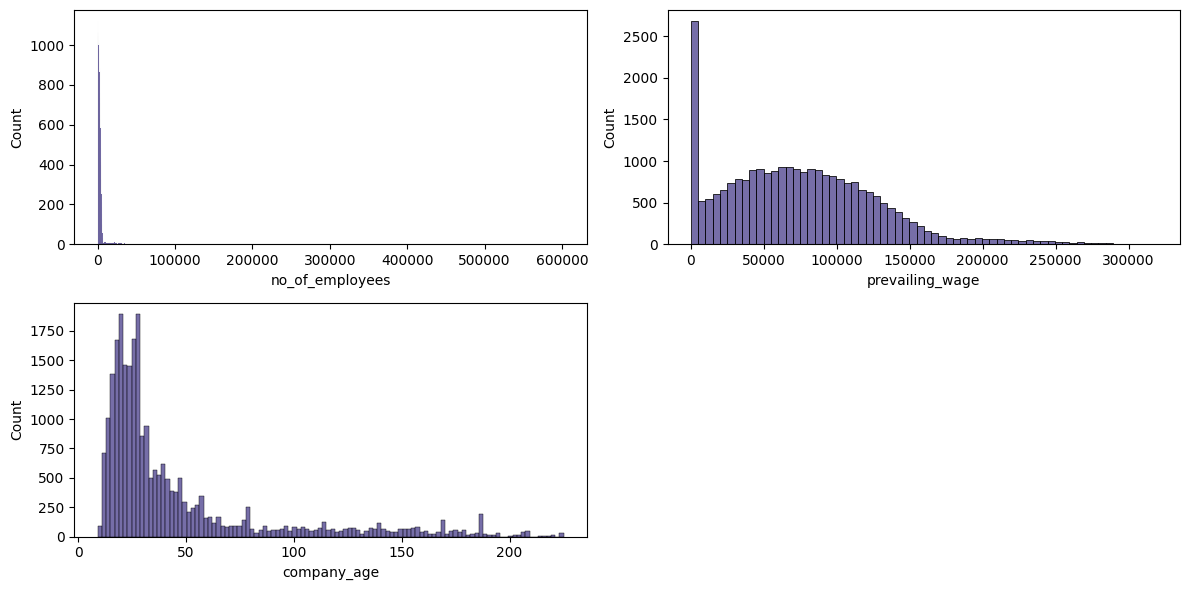

In [16]:
# Distribution of numerical data before scaling

plt.figure(figsize = (12, 6))
for i, col in enumerate(['no_of_employees', 'prevailing_wage', 'company_age']):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col], color = 'darkslateblue')
    plt.xlabel(col)
    plt.tight_layout()

- No of employees and Copmany age column is skewed

- Apply a power transformer featurewise to make data more Normally Distributed.

`Power transforms` are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the `Box-Cox transform` and the `Yeo-Johnson transform`.

**What is Skewness ?**

`Skewness` refers to a distortion or asymmetry that deviates from the symmetrical bell curve, or normal distribution, in a set of data. If the curve is shifted to the left or to the right, it is said to be skewed. Skewness can be quantified as a representation of the extent to which a given distribution varies from a normal distribution. A normal distribution has a skew of zero

In [17]:
# Checking skewness

X[continuous_features].skew(axis = 0, skipna = True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

Here company_age, no_of_employees are positively skewed, so we will apply a power transformer to these features.

#### Applying Power Transformer to check if it can reduces the outliers


In [21]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson')
transform_features = ['company_age', 'no_of_employees']

X_copy = pt.fit_transform(X[transform_features])


In [22]:
X_copy = pd.DataFrame(X_copy, columns = transform_features)

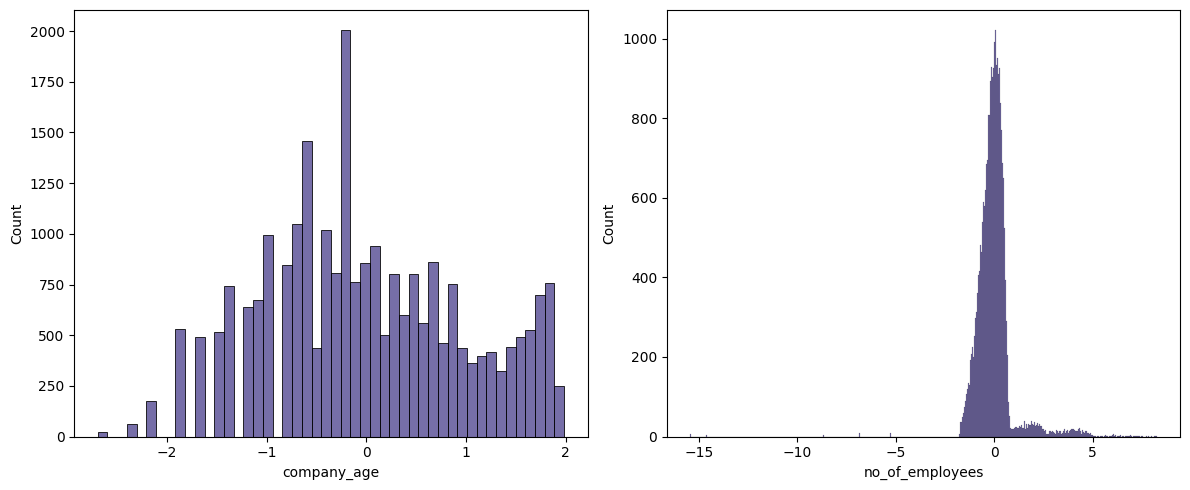

In [23]:
plt.figure(figsize = (12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x = X_copy[col], color ='darkslateblue')
    plt.xlabel(col)
    plt.tight_layout()

In [24]:
# Checking skewness

X_copy.skew(axis = 0, skipna = True)

company_age        0.112260
no_of_employees    0.399339
dtype: float64

- Here Yeo-Johnson is used and it supports both positive or negative data for transformation.

- So Power Transformer with yeo-johnson can be used.

### **Feature Encoding and Feature Scaling**

**One Hot Encoding for Columns which had lesser unique values and not ordinal**

- One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories**
 
- Ordinal encoding is used here as label encoder is supported for column transformer.

- Ordinal encoding is used for Ordinal Variable. An ordinal variable is a categorical variable with a natural, ranked order between categories.

**Standard Scaler**

- Standardize features by removing the mean and scaling to unit variance.

- Used when your numerical data is roughly normally distributed already.

**Power Transformer**

- Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

- Used when numerical data is highly skewed or has non-normal distributions.


In [25]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Numerical Features :', numerical_features)

Numerical Features : ['no_of_employees', 'prevailing_wage', 'company_age']


In [26]:
# Preprocessing using Column Transformer

# Ordinal Encoding for Columns which has many unique categories
ordinal_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
# One Hot Encoding for Columns which had lesser unique values and not ordinal
one_hot_columns = ['continent','unit_of_wage','region_of_employment']
# Transform columns that are highly skewed using Power Transformer
transform_columns = ['no_of_employees','company_age']

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

standard_scaler = StandardScaler()
one_hot_encoder = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipeline = Pipeline(steps = [
    ('transformer', PowerTransformer(method = 'yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", one_hot_encoder, one_hot_columns), # One Hot Encoding to columns with fewer unique values
        ("OrdinalEncoder", ordinal_encoder, ordinal_columns), # Ordinal Encoding to columns with many unique categories
        ("Transformer", transform_pipeline, transform_columns), # Power Transformer to highly skewed numerical features
        ("StandardScaler", standard_scaler, numerical_features), # Standard Scaler to all numerical features
    ]
)

In [28]:
X = preprocessor.fit_transform(X)

In [29]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])